# "2+1D" Pouch Cell Model

In this notebook we show how you can use PyBaMM to solve a "2+1D" pouch cell model. By "2+1D" we mean that the pouch cell is modelled by considering a number of 1+1D (pseudo-two-dimensional) models for the through-cell electrochemical behaviour coupled via a 2D model for the electrical behaviour in the current collectors. We also include thermal effects in the model, under the assumption that the temperature is uniform across the cell thickness (which is small compared with the remaining two dimensions). This results in a 2D model the thermal behaviour of cell. The model is fully-coupled, in the sense that the electrochemical behaviour (including the parameters) depends on the temperature.

## Example solving a pouch cell model using PyBaMM

Below we show how to change the model options to solve a pouch cell model in PyBaMM.

First we need to import `pybamm` and the other packages we will use in this notebook, and then change our working directory to the root of the pybamm folder. 

In [1]:
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

We then need to choose our model and set the appropriate options. The flexibility of PyBaMM allows you to choose any battery model to describe the through cell behaviour. Here we choose the SPM, in the interest of simplicity. 

In order to turn the model into a pouch cell model we pass options telling PyBaMM which current collector model to use and what dimension the current current collector model should take. We choose the "potential pair" model and set the "dimensionality" to 2, since we want a "2+1D" model. 

Additionally, we set the thermal model to "x-lumped" to reflect our model assumption that the temperature doesn't vary in the through-cell direction $x$.

In [2]:
# load (2+1D) SPM model
options = {
    "current collector": "potential pair",
    "dimensionality": 2,
    "thermal": "x-lumped",
}
model = pybamm.lithium_ion.SPM(options)

We then use the default model geometry and parameters, but increase the C-rate to 2. Information about the cell geometry and tab location is stored in the parameter file.

In [3]:
# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param = model.default_parameter_values
param.process_model(model)
param.process_geometry(geometry)

We then set the mesh and discretise the model. In this notebook we use a relatively coarse mesh, just to illustrate how to set up the problem. You can experiment with the number of grid points. For large systems we recommend using a sparse solver (see the instructions for installing SUNDIALS with KLU sparse solver [here](https://github.com/pybamm-team/PyBaMM/blob/master/INSTALL-LINUX.md)).

In [4]:
# choose number of grid points per domain
var = pybamm.standard_spatial_vars
var_pts = {
    var.x_n: 5,
    var.x_s: 5,
    var.x_p: 5,
    var.r_n: 5,
    var.r_p: 5,
    var.y: 10,
    var.z: 10,
}
# set mesh
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

# discretise model
timer = pybamm.Timer()
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
start = timer.time()
disc.process_model(model)
end = timer.time()
print("Discretised the {} in {:.3f} seconds".format(model.name, end-start))


Discretised the Single Particle Model in 47.023 seconds


Note that the discretisation is a one-off cost, and the discretised model can be saved for later use if you would like to run multiple simulations.

We can now solve the model in the usual way

In [5]:
# solve model
tau = param.evaluate(pybamm.standard_parameters_lithium_ion.tau_discharge)
t_end = 3600 / tau
t_eval = np.linspace(0, t_end, 100)
solution = pybamm.IDAKLUSolver(atol=1e-6, rtol=1e-3).solve(model, t_eval)
print("Solved the {} in {:.3f} seconds".format(model.name, solution.solve_time))


Solved the Single Particle Model in 7.269 seconds


Finally, we can plot some quantities of interest. At present, fully automated plotting for "2+1D" models isn't implemented, but we can still post-process the variables and create plots manually. In the future PyBaMM's `QuickPlot` functionality will be extended to work with models in higher macroscopic dimensions.

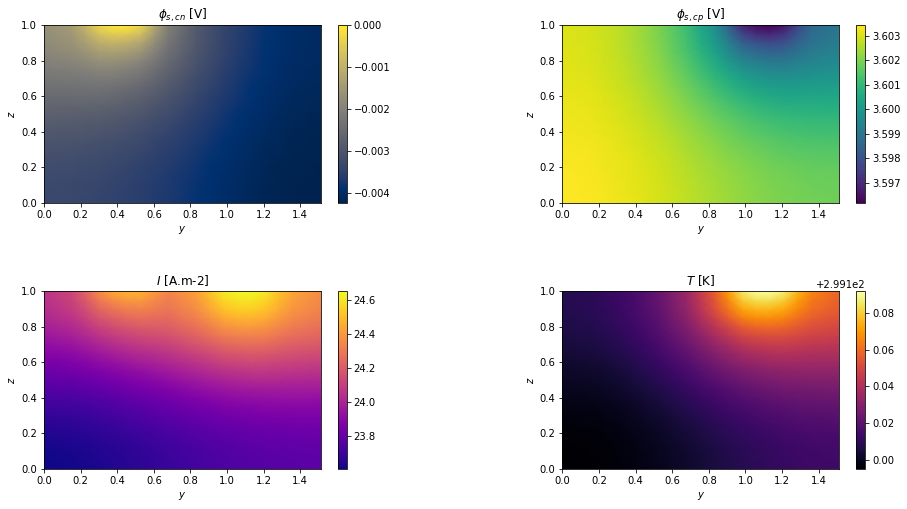

In [7]:
# TO DO: 2+1D automated plotting
phi_s_cn = pybamm.ProcessedVariable(
    model.variables["Negative current collector potential [V]"],
    solution.t,
    solution.y,
    mesh=mesh,
)
phi_s_cp = pybamm.ProcessedVariable(
    model.variables["Positive current collector potential [V]"],
    solution.t,
    solution.y,
    mesh=mesh,
)
I = pybamm.ProcessedVariable(
    model.variables["Current collector current density [A.m-2]"],
    solution.t,
    solution.y,
    mesh=mesh,
)
T = pybamm.ProcessedVariable(
    model.variables["X-averaged cell temperature [K]"],
    solution.t,
    solution.y,
    mesh=mesh,
)
l_y = phi_s_cp.y_sol[-1]
l_z = phi_s_cp.z_sol[-1]
y_plot = np.linspace(0, l_y, 21)
z_plot = np.linspace(0, l_z, 21)


def plot(t):
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplots_adjust(left=-0.1)

    # find t index
    ind = (np.abs(solution.t - t)).argmin()

    # negative current collector potential
    plt.subplot(221)
    phi_s_cn_plot = plt.pcolormesh(
        y_plot,
        z_plot,
        np.transpose(phi_s_cn(y=y_plot, z=z_plot, t=solution.t[ind])),
        shading="gouraud",
    )
    plt.axis([0, l_y, 0, l_z])
    plt.xlabel(r"$y$")
    plt.ylabel(r"$z$")
    plt.title(r"$\phi_{s,cn}$ [V]")
    plt.set_cmap("cividis")
    plt.colorbar(phi_s_cn_plot)

    # positive current collector potential
    plt.subplot(222)
    phi_s_cp_plot = plt.pcolormesh(
        y_plot,
        z_plot,
        np.transpose(phi_s_cp(y=y_plot, z=z_plot, t=solution.t[ind])),
        shading="gouraud",
    )

    plt.axis([0, l_y, 0, l_z])
    plt.xlabel(r"$y$")
    plt.ylabel(r"$z$")
    plt.title(r"$\phi_{s,cp}$ [V]")
    plt.set_cmap("viridis")
    plt.colorbar(phi_s_cp_plot)

    # current
    plt.subplot(223)
    I_plot = plt.pcolormesh(
        y_plot,
        z_plot,
        np.transpose(I(y=y_plot, z=z_plot, t=solution.t[ind])),
        shading="gouraud",
    )

    plt.axis([0, l_y, 0, l_z])
    plt.xlabel(r"$y$")
    plt.ylabel(r"$z$")
    plt.title(r"$I$ [A.m-2]")
    plt.set_cmap("plasma")
    plt.colorbar(I_plot)

    plt.subplots_adjust(
        top=0.92, bottom=0.15, left=0.10, right=0.9, hspace=0.5, wspace=0.5
    )

    # temperature
    plt.subplot(224)
    T_plot = plt.pcolormesh(
        y_plot,
        z_plot,
        np.transpose(T(y=y_plot, z=z_plot, t=solution.t[ind])),
        shading="gouraud",
    )

    plt.axis([0, l_y, 0, l_z])
    plt.xlabel(r"$y$")
    plt.ylabel(r"$z$")
    plt.title(r"$T$ [K]")
    plt.set_cmap("inferno")
    plt.colorbar(T_plot)

    plt.subplots_adjust(
        top=0.92, bottom=0.15, left=0.10, right=0.9, hspace=0.5, wspace=0.5
    )


plot(2700 / tau)
plt.show()